# Fernando Garcia Cortez
### Hands-on MCMC for beginners


In [79]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import time

##### Lab measurements

In [80]:
# True values
L_true  = 1.0 # meters
g_true  = 9.81 # m/s^2
T_exact = 2*np.pi*np.sqrt(L_true/g_true) # seconds

# Std dev for error in measurement of periods
sigma_T = 0.1 # seconds

# Fabricate data by appending a Gaussian error to the exact value
N = 30 # Number of measurements in the lab
measurements = T_exact + np.random.normal(0,sigma_T, size = N)

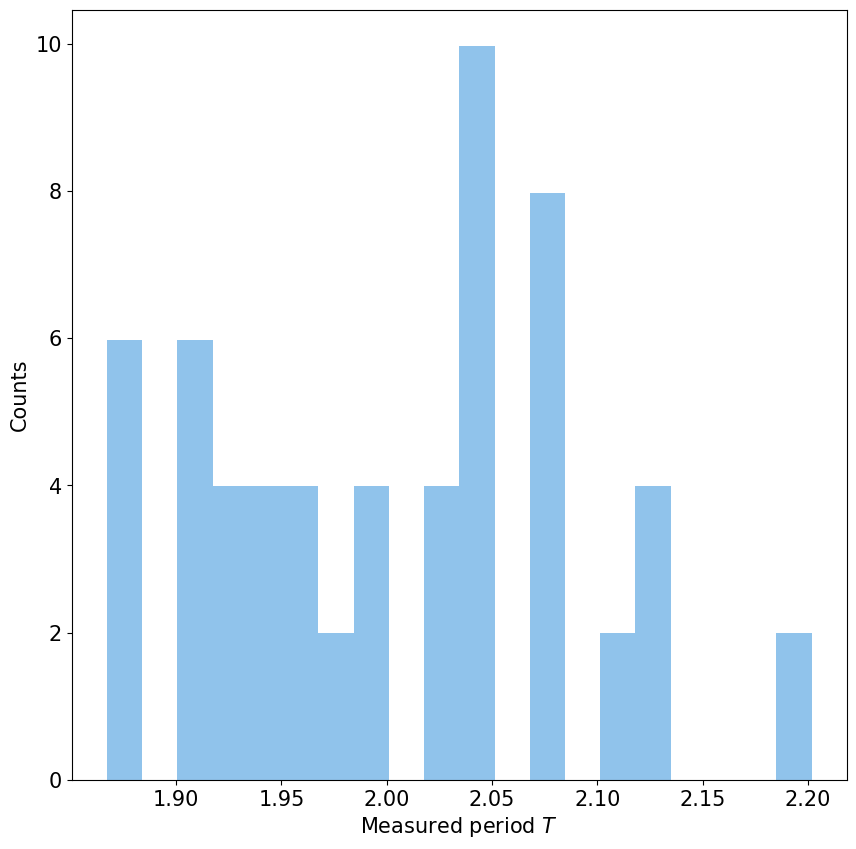

In [88]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', labelsize=15)
plt.hist(measurements, bins=20, density=True, color="#2389d8", alpha=0.5,label=f"Generated Data")
plt.xlabel(r"Measured period $T$",fontsize=15)
plt.ylabel(r"Counts",fontsize=15)
plt.savefig("observations_histogram.png",dpi=400, transparent=True,bbox_inches='tight')

**Function that computes the period, given a value of $g$.**

In [125]:
def period(g):
    return 2*np.pi*np.sqrt(L_true/g) # seconds

**Proposal function**

In [131]:
def gaussian_proposal(g_current,prop_sigma):
    return g_current + np.random.normal(0,prop_sigma)

**Log likelihood**

In [137]:
def log_likelihood(data,data_sigma,g):
    N_data = len(data)
    log_sum = np.sum((data - period(g))**2)
    return -N_data*np.log(data_sigma*np.sqrt(2*np.pi)) -(1/(2*data_sigma**2))*log_sum

**Log prior**
We assume a uniform prior over a sensible interval.

In [138]:
def log_prior(g):
    if 0 <= g <= 20:
        return 0
    else:
        return -np.inf

##### MCMC Code

In [139]:
# This function takes in the current value of g in parameter space.
# It proposes a new value and returns whether we perform a jump or not.
def MCMC_step(data,data_sigma,prop_sigma,g_current):
    # propose a new value
    g_proposed = gaussian_proposal(g_current,prop_sigma)
    # Compute (log) posteriors (up to multiplicative factor)
    log_current_posterior = log_prior(g_current) + log_likelihood(data,data_sigma,g_current)
    log_proposal_posterior = log_prior(g_proposed) + log_likelihood(data,data_sigma,g_proposed)
    diff = log_proposal_posterior - log_current_posterior
    if diff >= 0: # Automatic acceptance
        test = True
    else:
        if np.log(random.rand()) <= diff:
            test = True
        else:
            test = False
    return test, g_proposed

In [141]:
N_steps = 250000
MCMC_g = 1 # m/s^2. This acts as the starting point.
MCMC_sigma = 0.1 # m/s^2. How wide the sampler will propose values around the current value.
chain = []
accepted = 0

time_i = time.time()
for step in range(N_steps):
    acceptance, new_g = MCMC_step(measurements,sigma_T,MCMC_sigma,MCMC_g)
    if acceptance:
        MCMC_g = new_g
        accepted += 1
    chain.append(MCMC_g)
time_f = time.time()

print("The chain finished running.")
print(f"   >  Total time: {time_f-time_i:.4f} seconds")
print(f"   >  Acceptance rate: {accepted/N_steps:.4f}")

The chain finished running.
   >  Total time: 4.0120 seconds
   >  Acceptance rate: 0.8269


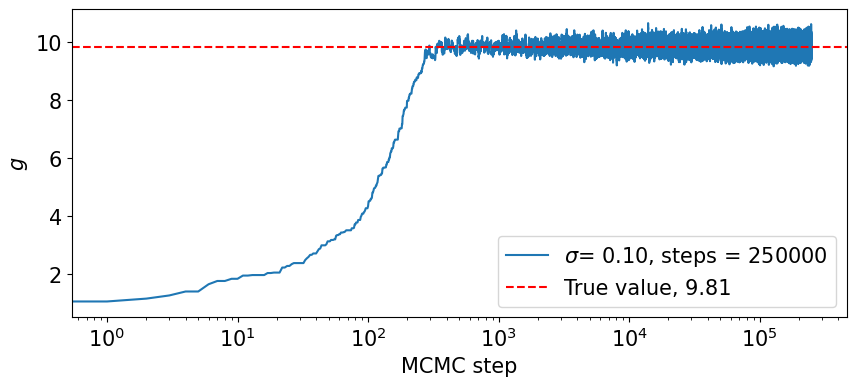

In [152]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.tick_params(axis='both', labelsize=15)
plt.plot(range(len(chain)),chain,label=fr"$\sigma $= {MCMC_sigma:.2f}, steps = {N_steps}")
ax.axhline(y=g_true, color='red', linestyle='--', label=f'True value, {g_true:.2f}')
plt.xlabel("MCMC step",fontsize=15) 
plt.ylabel(r"$g$",fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.savefig("chain.png",dpi=400, transparent=True,bbox_inches='tight')

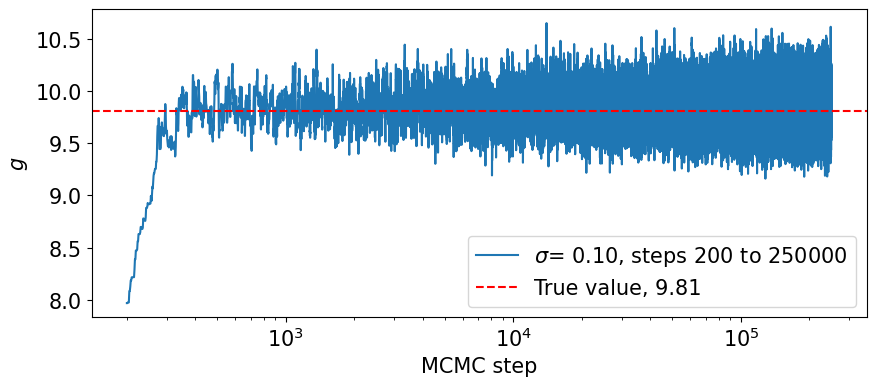

In [153]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.tick_params(axis='both', labelsize=15)
plt.plot(range(len(chain))[200:],chain[200:],label=fr"$\sigma $= {MCMC_sigma:.2f}, steps 200 to {N_steps}")
ax.axhline(y=g_true, color='red', linestyle='--', label=f'True value, {g_true:.2f}')
plt.xlabel("MCMC step",fontsize=15) 
plt.ylabel(r"$g$",fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')
plt.savefig("chain_minus_burn_in.png",dpi=400, transparent=True,bbox_inches='tight')

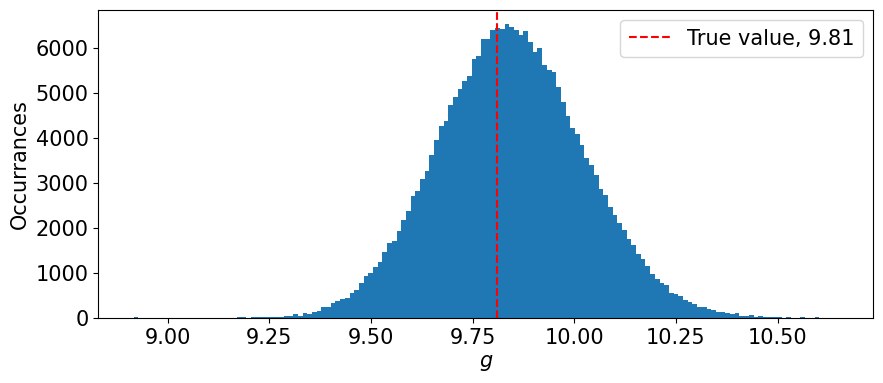

In [158]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.tick_params(axis='both', labelsize=15)
plt.hist(chain[250:],bins=150)
ax.axvline(x=g_true, color='red', linestyle='--', label=f'True value, {g_true:.2f}')
plt.xlabel("$g$",fontsize=15) 
plt.ylabel(r"Occurrances",fontsize=15)
plt.legend(fontsize=15)
plt.savefig("chain_histogram.png",dpi=400, transparent=True,bbox_inches='tight')

In [157]:
print(np.mean(chain[250:]))
print(np.median(chain[250:]))
print(np.std(chain[250:]))

9.84501021087347
9.842251038826094
0.17941920815431725
